In [1]:
import pickle as pkl
import os
import numpy as np
from alignment_helper_fns import *
from sklearn.linear_model import LinearRegression
from audio_utils import *
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
PHONEME_INFO_DF = PHONEME_INFO_DF.set_index('phoneme')

EXCLUDE_FILES = ['0505_M_EKs4T10', '0411_M_LMwT32']
audio_dir = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'
manual_textgrids_dir = '/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/'
xvectg_dir = '/home/prad/github/charsiu/results_xvector_reevaluated'
mfa_sat_dir = '/home/prad/datasets/ChildSpeechDataset/results_mfa_adapted/'
w2v_dir = './results_xvector_reevaluated/'
intelligdf = pd.read_csv('./adjust-adjusted-intelligibility.csv')
intelligdf = intelligdf.rename(columns={'Unnamed: 0': 'speaker'})
kaldi_gops = pd.read_csv('./child_speech_gops.csv')
all_speakers = np.unique(kaldi_gops.speaker.values)
# mfa_sat_dir = '/home/prad/datasets/ChildSpeechDataset/mfa_with_sat/'

unmatched_manual_textgrid_files = get_all_textgrids_in_directory(manual_textgrids_dir)
aligner_textgrid_files = get_all_textgrids_in_directory(mfa_sat_dir)
candidate_aligner_textgrid_files = get_all_textgrids_in_directory(w2v_dir)
manual_textgrid_files = []
audio_files = ['/'.join([audio_dir,_path.split('/')[-2], _path.split('/')[-1][:-8]+'wav'])
               for _path in unmatched_manual_textgrid_files]

from create_child_speech_dataset import *
from gop_helper_fns import *

'''
need to match the corresponding files since the files loaded from the code above are out of order
'''
mismatched_phoneme = 0
mismatched_lengths = 0
print(len(aligner_textgrid_files))
for ii, aligned_tg_file in tqdm.tqdm(enumerate(aligner_textgrid_files)):
#     print(ii)
    _filename = aligned_tg_file.split('/')[-1].replace('-', '_')
#     print(_filename)
    matching_ind = int(np.argwhere([_filename in manual_file for manual_file in unmatched_manual_textgrid_files]).ravel())
#     print(matching_ind)
    matching_gt_file = unmatched_manual_textgrid_files[matching_ind]
    manual_textgrid_files.append(matching_gt_file)
    
manual_textgrid_files = [tg for tg in manual_textgrid_files if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]
len(manual_textgrid_files)

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/


43it [00:00, 4231.20it/s]


Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/results_mfa_adapted/


43it [00:00, 4619.63it/s]


Extracting all textgrids in directory:	 ./results_xvector_reevaluated/


43it [00:00, 6894.83it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


3764


3764it [00:01, 2260.21it/s]


3762

In [3]:
def get_all_phones_of_type(descriptions, removephones= None):
    from phoneme_info import PHONEME_INFO_DF
    # PHONEME_INFO_DF = PHONEME_INFO_DF.set_index('phoneme')
    phones = []
    for descrip in descriptions:
        _phns = list(PHONEME_INFO_DF[PHONEME_INFO_DF['type'].str.contains(descrip)].phoneme)
        phones.extend(_phns)
    
    phones = set(phones)
    
    if removephones is not None:
        for rphn in removephones:
            phones.discard(rphn)
    return list(phones)

stops = get_all_phones_of_type(['stop', 'plosive'], removephones=['CH'])
stops = set(stops)
stops.discard('CH')
stops = list(stops)
# fortis = 
# liquids = get_
print(stops)
fricatives = get_all_phones_of_type(['fricative'], removephones=['CH']) + get_all_phones_of_type(['affricate'], removephones=['CH'])
unvoiced_fricatives = ['F', 'TH', 'S', 'SH']
voiced_fricatives = ['V', 'DH', 'Z']
liquid_approximants = ['R', 'L']
glide_approximants = ['JH', 'W']
nasals = ['NG', 'N', 'M']
vowels = get_all_phones_of_type(['vowel'])
obstruents = stops + fricatives
affricates = ['JH', 'CH']



['B', 'DH', 'D', 'K', 'T', 'P', 'G']


In [4]:
phone_classes_dct = {
    'Stops': stops, 
    'UnvoicedFricatives':unvoiced_fricatives, 
    'VoicedFricatives': voiced_fricatives,
    'LiquidApproximants': liquid_approximants,
    'GlideApproximants':glide_approximants,
    'Nasals': nasals,
    'Vowels': vowels,
    'Obstruents': obstruents,
    'Affricates': affricates}

In [10]:
pllrdct = pkl.load(open('./speakerwise_gops_and_durations.pkl', 'rb'))

In [18]:
fulldf_cols = ['PhoneType', 'Phoneme', 'OccurencePLLR', 'PhoneDuration', 'Age', 'Speaker']
fulldf = pd.DataFrame(columns=fulldf_cols)

for speaker, phonepllrs in pllrdct.items():
    speaker_age = float(speaker[1])+ float(speaker[2:4])/12
    
    for phonetype, phonesubset in phone_classes_dct.items():
        # print(phonetype, phonesubset)
        subtypepllrs = []
        subtypedurations = []
        phoneid = []
        for phn in phonesubset:
            # phonepllrs[phn]
            try:
                subtypepllrs.extend(phonepllrs[phn]['pllrs'])
                subtypedurations.extend(phonepllrs[phn]['durations'])
                phoneid.extend([phn]*len(phonepllrs[phn]['pllrs']))
            except:
                print(f'No occurences of phone: {phn} found for speaker: {speaker}')

        # print(subtypedurations)
        n_occurences = len(subtypepllrs)
        _data = np.array([[phonetype] * n_occurences, phoneid, subtypepllrs, subtypedurations, [speaker_age] * n_occurences, [speaker] * n_occurences]).T
        typedf = pd.DataFrame(_data, columns = fulldf_cols)

        fulldf = pd.concat((fulldf, typedf), axis=0)

In [19]:
fulldf['Age'] = fulldf['Age'].astype('float')
fulldf['OccurencePLLR'] = fulldf['OccurencePLLR'].astype('float')
fulldf['PhoneDuration'] = fulldf['PhoneDuration'].astype('float')

In [20]:
fulldf.to_csv('phone_subtype_occurence_pllrs.csv')

Stops ['B', 'K', 'T', 'G', 'DH', 'D', 'P']
Corr:  0.21
Spearman:  0.22


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


UnvoicedFricatives ['F', 'TH', 'S', 'SH']
Corr:  0.21
Spearman:  0.25


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


VoicedFricatives ['V', 'DH', 'Z']
Corr:  0.25
Spearman:  0.29


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


LiquidApproximants ['R', 'L']
Corr:  0.14
Spearman:  0.16


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


GlideApproximants ['JH', 'W']
Corr:  0.18
Spearman:  0.19


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Nasals ['NG', 'N', 'M']
Corr:  0.14
Spearman:  0.17


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Vowels ['UW', 'Y', 'OY', 'AY', 'EH', 'AO', 'AW', 'OW', 'UH', 'IY', 'ER', 'AA', 'AE', 'AH', 'IH', 'EY']
Corr:  0.17
Spearman:  0.18


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Obstruents ['B', 'K', 'T', 'G', 'DH', 'D', 'P', 'S', 'HH', 'SH', 'TH', 'Z', 'F', 'JH', 'V']
Corr:  0.20
Spearman:  0.22


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Affricates ['JH', 'SH', 'CH']
Corr:  0.28
Spearman:  0.31


/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


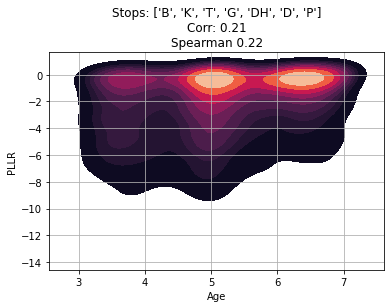

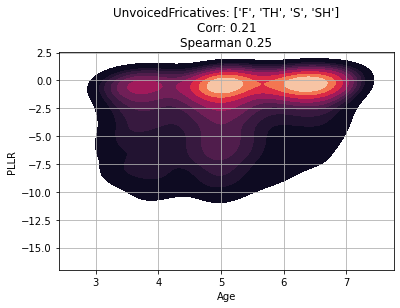

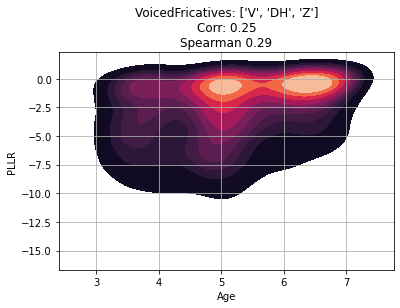

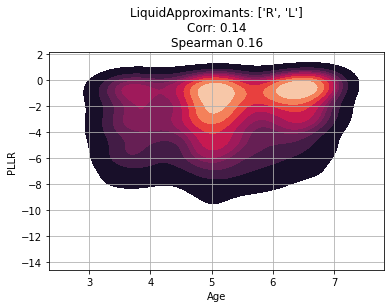

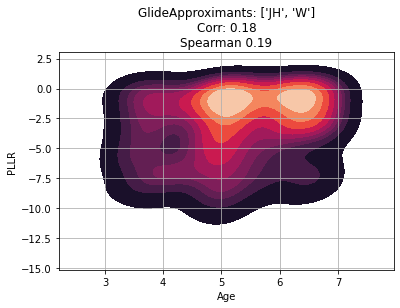

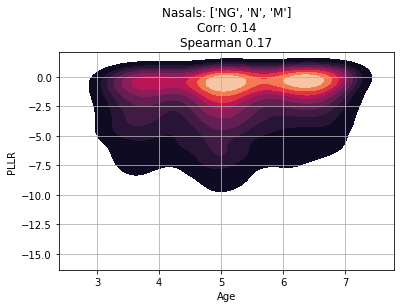

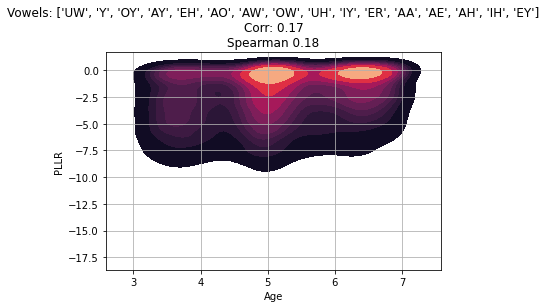

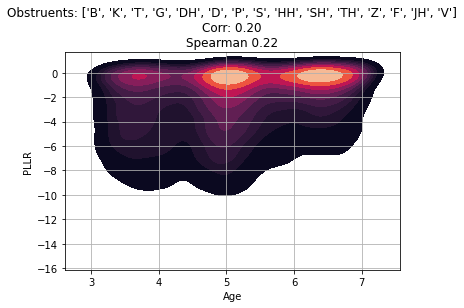

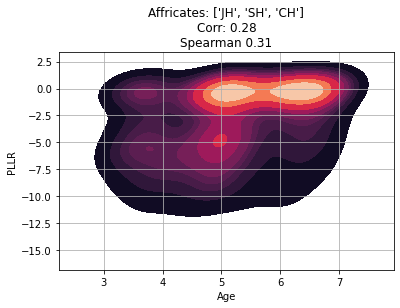

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
for phonetype, phonesubset in phone_classes_dct.items():
    print(phonetype, phonesubset)
    plt.figure()
    typedf = fulldf[fulldf.PhoneType==phonetype]
    x = typedf.Age.values.astype('float')
    y = typedf.OccurencePLLR.values.astype('float')
    print(f'Corr: {np.corrcoef(x, y)[0,1]: .2f}')
    print(f"Spearman: {spearmanr(x, y)[0]: .2f}")
    sns.kdeplot(x, y, fill=True, cmap= sns.cm.rocket)
    # plt.scatter(typedf.Age.values.astype('float'), typedf.OccurencePLLR.values.astype('float'), marker='.')
    # print(typedf.OccurencePLLR)
    plt.xlabel('Age')
    plt.ylabel('PLLR')
    plt.title(f'{phonetype}: {str(phonesubset)}\nCorr:{np.corrcoef(x, y)[0,1]: .2f}\nSpearman{spearmanr(x, y)[0]: .2f}')
    plt.grid()
    # break

- remove sh from affricates
- average occurence pllrs across speaker, then vs age
- remove age from both PLLR and from intelligibility before correlating
- intellig  - a*age = b*pllr + c
    - what unaccounted signal in intelligibility is explained by pllr
- Ideally:
    - intellig = a*age + b*pllr + d*age*pllr + c

In [37]:
%%html
<style>
table {float:left}
</style>

In [36]:

typedf['OccurencePLLR']

0    -5.752039
1    -5.832241
2     0.000000
3    -8.275704
4    -5.921684
        ...   
18   -0.289418
19   -0.274659
20   -0.029951
21   -0.208398
22   -0.129397
Name: OccurencePLLR, Length: 800, dtype: float64

In [25]:
typedf.groupby(['Speaker'])['OccurencePLLR'].float().mean()

AttributeError: 'SeriesGroupBy' object has no attribute 'float'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for phonetype, phonesubset in phone_classes_dct.items():
    print(phonetype)
    plt.figure()
    typedf = fulldf[fulldf.PhoneType==phonetype]
    x = typedf.Age.values.astype('float')
    y = typedf.OccurencePLLR.values.astype('float')
    sns.kdeplot(x, y, fill=True, cmap= sns.cm.rocket)
    # plt.scatter(typedf.Age.values.astype('float'), typedf.OccurencePLLR.values.astype('float'), marker='.')
    # print(typedf.OccurencePLLR)
    plt.xlabel('Age')
    plt.ylabel('PLLR')
    plt.title(f'{phonetype}: {str(phonesubset)}\nCorr:{np.corrcoef(x, y)[0,1]: .2f}\nSpearman{spearmanr(x, y)[0]: .2f}')
    plt.grid()
    # break

In [27]:
typedf.Age.values

array(['3.25', '3.25', '3.25', ..., '6.916666666666667',
       '6.916666666666667', '6.916666666666667'], dtype=object)

In [28]:
typedf.OccurencePLLR.values

array(['-1.174513339996338', '-3.700394630432129', '-3.233654737472534',
       ..., '0.0', '0.0', '0.0'], dtype=object)

In [15]:
f"{str(['a', 's', 'd'])}"

"['a', 's', 'd']"

In [ ]:
''' 

DEFINE PHONE SUBSETS

'''
stops =  ['P', 'B', 'D', 'G', 'K', 'T']
fricatives = ['F', '']
PLLR_SUBSET_DICT = {
    'STOPS': stops,
    '': ,
    ''
}